# Set up

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy

In [10]:
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999')
              # D = dominant = right; N = nondominant = left
yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## Import & manage data (all trials), pilot data

In [11]:
#import all data from git
path0 = 'C:/Users/amber/Documents/GitHub/sensorimotor_fusion/data/linearity_stimuli_example'
# function that filters npz files
def fun(f):
    if f.endswith('.npz') and not f.endswith('rst0.npz') and not f.endswith('rst1.npz') and not f.endswith('rst2.npz'):
        return True
    else:
        return False

files_0 = os.listdir(path0) 
files_0 = list(filter(fun, files_0))
files_0

['20230511-123313_Fusion23so_dis_demoing_so_r-sos-E_d-sos+O_s49_p0a1.npz',
 '20230511-123417_Fusion23so_ref_demoing_so_r-sos-O_d-sos+E_s49_p1a2.npz']

In [12]:
DEMO = {}
i = 0
for trials in files_0:
    #make a dict for each trial in the folder
    trial = dict(np.load(os.path.join(path0, trials), allow_pickle=True))
    #delete "filename"
    del trial['filename']
    #eliminate first 5 seconds of data
    for k in range(len(trial.keys())):
      trial[list(trial.keys())[k]] = trial[list(trial.keys())[k]][301:-1]
    #create a nested dict, including all trials
    DEMO['trial'+str(i)] = trial
    i+=1

DEMO.keys()

dict_keys(['trial0', 'trial1'])

In [13]:
DEMO['trial0'].keys()

dict_keys(['inp_', 'realtime_', 'ref_', 'time_', 'inp0_', 'out_', 'state_', 'dis_', 'inp1_'])

# Data Analysis

In [14]:
def FFT(data,N):
  return fft.fft(data)/N

def IFFT(data,N):
  return (fft.ifft(data)*N).real

M = lambda s : 1/(s**2 + s)

num_cond = 7 #number of conditions

scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

#parameters (same for all three conditions)
trialnum0 = len(DEMO.keys())         #number of data trials, trial0 ~ trial3

trialnum = [trialnum0]

fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(DEMO['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = DEMO['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers

stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

def Analysis(data,trialnum):

  r = []      #r, reference (time)
  Md = []     #Md, disturbance (time)
  y = []      #y, output (time)
  r_h = []    #r_hat, reference (freq)
  y_h = []    #y_hat, output (freq)
  Md_h = []   #Md_hat, disturbance (freq)
  Wr_h = []   #Wr_hat, M^{-1}r_hat (freq)
  Wr = []     #Wr, M^{-1}r (time)
  u_h = []    #u_hat, input (freq)
  u = []      #u, input (time)
  u0_h = []   #u0_hat, emg input (freq)
  u0 = []     #u0, emg input (time)
  u1_h = []   #u1_hat, slider input (freq)
  u1 = []     #u1, slider input (time)
  d_h = []    #d_hat, disturbance (freq)
  d = []      #d, disturbance (time)

  for i in range(trialnum):
    
    #(1) output 
    r.append( data['trial'+str(i)]['ref_'] )
    d.append( data['trial'+str(i)]['dis_'] )
    y.append( data['trial'+str(i)]['out_'] )
    
    #(2) fft (entire freq term)
    r_h.append( FFT(r[i],N) )
    y_h.append( FFT(y[i],N) )
    d_h.append( FFT(d[i],N) )

    #(3) M^{-1}r_hat = Wr_hat = r_hat / M_hat in freq domain and Wr in time domain
    Wr_h.append( r_h[i] / M_h )
    Wr_h[i][0] = 0 #nan
    Wr.append( IFFT(Wr_h[i],N) )
    
    #(4) input(u): u_hat in freq domain and u in time domain
    u_h.append( FFT(data['trial'+str(i)]['inp_'],N) ) #combined input
    u.append( IFFT(u_h[i],N) )

    u0_h.append( FFT(data['trial'+str(i)]['inp0_'],N) ) #seperated emg input
    u0.append( IFFT(u0_h[i],N) )

    u1_h.append( FFT(data['trial'+str(i)]['inp1_'],N) ) #seperated slider input 
    u1.append( IFFT(u1_h[i],N) )

    #(5) disturbance(d): d_hat = Md_hat/M_hat in freq domain and d in time domain
    Md_h.append( d_h[i] * M_h )
    Md_h[i][0] = 0 #nan
    Md.append( IFFT(Md_h[i],N) )

    #output scaling
    r[i] = r[i]*scaleOutputScreen
    y[i] = y[i]*scaleOutputScreen
    Md[i] = Md[i]*scaleOutputScreen
    r_h[i] = r_h[i]*scaleOutputScreen
    y_h[i] = y_h[i]*scaleOutputScreen
    Md_h[i] = Md_h[i]*scaleOutputScreen

    #input scaling
    d[i] = d[i]*scaleInput
    Wr[i] = Wr[i]*scaleInput
    u[i] = u[i]*scaleInput
    u0[i] = u0[i]*scaleInput
    u1[i] = u1[i]*scaleInput
    d_h[i] = d_h[i]*scaleInput
    Wr_h[i] = Wr_h[i]*scaleInput
    u_h[i] = u_h[i]*scaleInput
    u0_h[i] = u0_h[i]*scaleInput
    u1_h[i] = u1_h[i]*scaleInput    

  #create dict
  time_domain = {'Md':Md,'r':r,'y':y,'d':d,'Wr':Wr,'u':u,'u0':u0,'u1':u1} #time domain
  freq_domain = {'MD':Md_h,'R':r_h,'Y':y_h,'D':d_h,'WR':Wr_h,'U':u_h,'U0':u0_h,'U1':u1_h} #freq domain

  return time_domain, freq_domain

<ipython-input-14-d18c82c494ed>:7: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s)
<ipython-input-14-d18c82c494ed>:7: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s)


In [15]:
time_slider, freq_slider = Analysis(DEMO,trialnum[0])

<ipython-input-14-d18c82c494ed>:64: RuntimeWarning: invalid value encountered in true_divide
  Wr_h.append( r_h[i] / M_h )
<ipython-input-14-d18c82c494ed>:79: RuntimeWarning: invalid value encountered in multiply
  Md_h.append( d_h[i] * M_h )


## plot stimuli

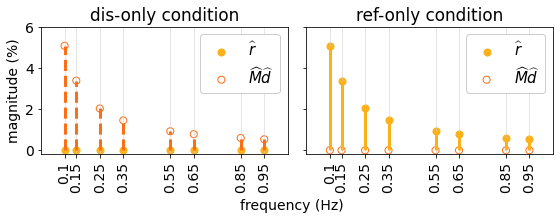

In [16]:
# plt.figure(figsize=(8, 2))
p = 10 #subject number
c = 2 #condition number

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

fig,axs = plt.subplots(1, 2,sharex = True,sharey = True,figsize=(8, 3)) 

xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)

ax = axs[0]
i = 0 #trial number
ax.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8',alpha = 0.5)
R = np.abs( freq_slider['R'][i][:N//2] )
MD = np.abs( freq_slider['MD'][i][:N//2] )
ax.scatter(xf[stimulated_index],100*R[stimulated_index], color=colors['r'],label=r'$\widehat{r}$',s=50)
ax.scatter(xf[stimulated_index],100*MD[stimulated_index], color=colors['d'],label=r'$\widehat{M}\widehat{d}$',facecolors='none',s=50)
ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*R[stimulated_index],color=colors['r'],linewidth = 3)
ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*MD[stimulated_index],linestyles='--',color=colors['d'],linewidth = 3)
ax.set_xlim((0,21*base_freq))
ax.set_ylim((-0.2,6))
# ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('magnitude (%)')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_title('dis-only condition')
# ax.legend( loc='upper right', ncol=2, frameon=True)
ax.legend( loc='upper right', ncol=1, frameon=True, prop={'size': 15},facecolor = 'white',framealpha = 1)


ax = axs[1]
i = 1 #trial number
ax.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8',alpha = 0.5)
R = np.abs( freq_slider['R'][i][:N//2] )
MD = np.abs( freq_slider['MD'][i][:N//2] )
ax.scatter(xf[stimulated_index],100*R[stimulated_index], color=colors['r'],label=r'$\widehat{r}$',s=50)
ax.scatter(xf[stimulated_index],100*MD[stimulated_index], color=colors['d'],label=r'$\widehat{M}\widehat{d}$',facecolors='none',s=50)
ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*R[stimulated_index],color=colors['r'],linewidth = 3)
ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*MD[stimulated_index],linestyles='--',color=colors['d'],linewidth = 3)
ax.set_xlim((0,21*base_freq))
ax.set_ylim((-0.2,6))
# ax.set_xlabel('frequency (Hz)')
# ax.set_ylabel('magnitude (%)')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_title('ref-only condition')
ax.legend( loc='upper right', ncol=1, frameon=True, prop={'size': 15},facecolor = 'white',framealpha = 1)
fig.text(0.52, -0.01, 'frequency (Hz)', ha='center',wrap=True)

plt.tight_layout()
plt.show()